# Model fitting

A lot of chemical analysis relies on our ability to fit a "line of best fit" to some data. 
For example, considering the determination of the activation energy, $E_a$, of some reaction from an Arrhenius relationship, 

$$ k(T) = A \exp{\frac{-E_a}{RT}}, $$

where, $k(T)$ is the rate constant at time $T$, $A$ is the pre-exponential factor, $R$ is the ideal gas constant and $T$ is the temperature. 
Typically when we are performing our analysis, we will rearrange the above equation to give a straight line, 

$$ \ln{k(T)} = \ln{A} - \frac{E_a}{RT}. $$

Let's looks at some experimental data for the decomposition of 2 moles of NO<sub>2</sub> to 2 moles of NO and one mole of O<sub>2</sub>.
The data for this is available [in this file](https://raw.githubusercontent.com/pythoninchemistry/ch40208/master/CH40208/working_with_data/arrhenius.txt). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T, k = np.loadtxt('arrhenius.txt', unpack=True)

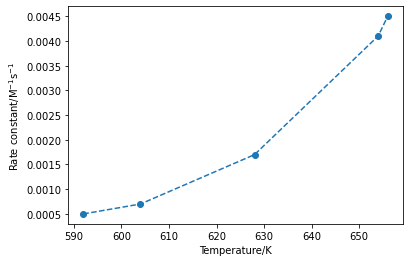

In [3]:
plt.plot(T, k, 'o--')
plt.xlabel('Temperature/K')
plt.ylabel('Rate constant/M$^{-1}$s$^{-1}$')
plt.show()

Alternatively, we plot this as a straight line.

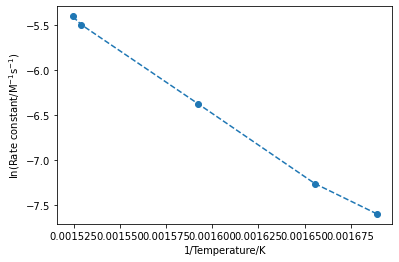

In [4]:
plt.plot(1/T, np.log(k), 'o--')
plt.xlabel('1/Temperature/K')
plt.ylabel('ln(Rate constant/M$^{-1}$s$^{-1}$)')
plt.show()

Using Python, we can fit this data in either configuration, either by performing a [linear regression](https://en.wikipedia.org/wiki/Linear_regression) or by fitting a line of best fit.

## Linear regression

Linear regression is a relatively simple mathematical process, that is implemented in the `scipy.stats` module. 

In [5]:
from scipy.stats import linregress

If we investigate the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) for the `linregress` function, we will see that we pass two arrays; `x` and `y`. 
These corresponding exactly to the *x* and *y*-axes of the plot above. 

In [6]:
result = linregress(1/T, np.log(k))

In [7]:
result

LinregressResult(slope=-13509.355973303444, intercept=15.161037389899018, rvalue=-0.998952302406746, pvalue=4.070235273533486e-05, stderr=357.31270179790863)

We can see that the object that is returned contains a couple of pieces of information. 
The two parts that we are most interested in are the `slope` and the `intercept`, which are attributes of the `result` object and can be obtained as follows.

In [8]:
print(result.slope)

-13509.355973303444


In [9]:
print(result.intercept)

15.161037389899018


Therefore, we can evaluate the activation energy and the pre-exponential factor as follows. 

In [11]:
from scipy.constants import R

In [12]:
activation_energy = - R * result.slope
preexponential_factor = np.exp(result.intercept)

In [13]:
print(f"A = {preexponential_factor}; E_a = {activation_energy}")

A = 3840209.1525825486; E_a = 112323.03523328649


Finally, we can plot our linear regression line through the data as shown below. 

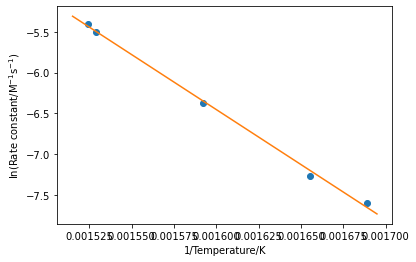

In [14]:
x = np.linspace(1/660, 1/590, 1000)

plt.plot(1/T, np.log(k), 'o')
plt.plot(x, result.slope * x + result.intercept, '-')
plt.xlabel('1/Temperature/K')
plt.ylabel('ln(Rate constant/M$^{-1}$s$^{-1}$)')
plt.show()

## Non-linear regression

Of course, our equation cannot always be modified to offer a straight line formulation or we may not want to as the logarithmic scaling of the *y*-axis may skew our understanding of the intercept. 
Therefore, necessary to fit a non-linear relationship. 
This can also be achieved with Python by minimising the difference between our model (the equation with given parameters) and the data. 
The value that we will minimize is known as the $\chi^2$-value, which has the following definitions.

$$ \chi^2 = \sum\big\{[y - f(x)] ^ 2\big\} \;\;\;\text{or}\;\;\; \chi^2 = \sum\Bigg\{\frac{[y - f(x)] ^ 2}{y_{\text{err}}^2}\Bigg\},$$

depending on whether or not uncertainty in the data is known. 

Consider the following data, which describe the decomposition of hyodrgen peroxide in the presence of excess cerous ion Ce<sup>III</sup>,

2H<sub>2</sub>O<sub>2</sub> + 2Ce<sup>III</sup> &rarr; 2H<sub>2</sub>O + Ce<sup>IV</sup> + O<sub>2</sub>.

| Time/s | 2 | 4 | 6 | 8 | 10 | 12 | 14 | 16 | 18 | 20 |
|---|---|---|---|---|---|---|---|---|---|---|
| [H<sub>2</sub>O<sub>2</sub>]/moldm<sup>-3</sup> | 6.23 | 4.84 | 3.76 | 3.20 | 2.60 | 2.16 | 1.85 | 1.49 | 1.27 | 1.01 |

First, we will store these values as NumPy arrays. 

In [15]:
c = np.array([6.23, 4.84, 3.76, 3.20, 2.60, 2.16, 1.85, 1.49, 1.27, 1.01])
t = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

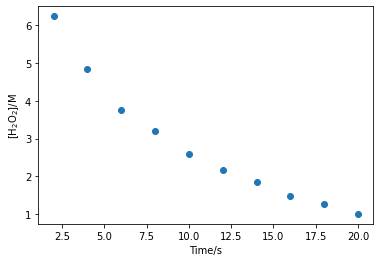

In [16]:
plt.plot(t, c, 'o')
plt.xlabel('Time/s')
plt.ylabel('[H$_2$O$_2$]/M')
plt.show()

This reaction has a first-order rate equation, this will be our "model" that we will compare to the data, where the $[A]_0$ and $k$ are the varying parameters. 
This function is defined below.

In [17]:
def first_order(t, a0, k):
    """
    The first-order rate equation. 
    
    Args:
        t (float): Time (s).
        a0 (float): Initial concentration (mol/dm3).
        k (float): Rate constant (s-1).
    
    Returns:
        (float): Concentration at time t (mol/dm3).
    """
    return a0 * np.exp(-k * t)

We want to vary `a0` and `k` to minimise the $\chi^2$-value between this model and the data. 

In [18]:
def chi_squared(x, t, data):
    """
    Determine the chi-squared value for a first-order rate equation.
    
    Args:
        x (list): The variable parameters.
        t (float): Time (s).
        data (float): Experimental concentration data.
    
    Returns:
        (float): chi^2 value.
    """
    a0 = x[0]
    k = x[1]
    return np.sum((data - first_order(t, a0, k)) ** 2)

Just like the minimisation of a potential model.
We can use the `scipy.optimize.minimize` to minimize this chi-squared function. 

In [19]:
from scipy.optimize import minimize

In [20]:
result = minimize(chi_squared, [10, 1], args=(t, c))

In [21]:
result

      fun: 0.13373044840242304
 hess_inv: array([[7.88766485e-01, 1.26315647e-02],
       [1.26315647e-02, 3.02236789e-04]])
      jac: array([1.41561031e-07, 2.03773379e-06])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 10
     njev: 21
   status: 0
  success: True
        x: array([7.42164414, 0.10308256])

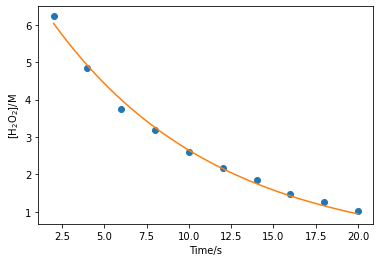

In [22]:
x = np.linspace(2, 20, 1000)

plt.plot(t, c, 'o')
plt.plot(x, first_order(x, result.x[0], result.x[1]))
plt.xlabel('Time/s')
plt.ylabel('[H$_2$O$_2$]/M')
plt.show()

In [23]:
print(f"[A]_0 = {result.x[0]}; k = {result.x[1]}")

[A]_0 = 7.421644139156653; k = 0.10308255571543631


`scipy.optimize.curve_fit` offers a convenient wrapper around this methodology, and makes it easy to access the estimated parameter uncertainties.

In [24]:
from scipy.optimize import curve_fit

In [25]:
popt, pcov = curve_fit(first_order, t, c)

<ipython-input-17-ef183409b30e>:13: RuntimeWarning: overflow encountered in exp
  return a0 * np.exp(-k * t)


We can ignore the above error, this is just warning that during the optimization an unphysical value was found.
However, the `curve_fit` function is robust enough to ignore this and continue. 

In [26]:
uncertainties = np.sqrt(pcov)

print(f"[A]_0 = {popt[0]} +/- {uncertainties[0][0]}; k = {popt[1]} +/- {uncertainties[1][1]}")

[A]_0 = 7.42164476326434 +/- 0.15838876657483184; k = 0.10308257141927114 +/- 0.00308836766268339


## Exercise

1. Modify the above first-order rate fitting using the `minimize` method to consider a *y*-uncertainty of 5 %. 
2. By investigating the [documentation for the `scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), determine how this uncertainty would be included in the `curve_fit` method.